# Case Study: testing




In [1]:
# imports from packages
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec # gridspec for nested subfigures
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import sys # to test parts of code with sys.exit()


In [2]:
# --- Global formatting/settings/variables

# formatting for only showing time on the x-axis for plots per flight
# Use by setting axs[1,0].xaxis.set_major_formatter(formatter) for each axis where only time should show
formatter = mdates.DateFormatter('%H:%M')

# colors for flights (to use all the same colors!
c_flights = {'IS22-01':'wheat',
              'IS22-02':'tab:green',
              'IS22-03':'tab:red',
              'IS22-04':'tab:purple',
              'IS22-05':'tab:blue',
              'IS22-06':'tab:brown',
              'IS22-07':'tab:gray',
              'IS22-08':'tab:olive',
              'IS22-09':'tab:cyan',
              'IS22-10':'tab:pink',
              'IS22-11':'tab:orange'}

# Threshold for in-cloud values
# following the korolev 22 paper: "In the present study the thresholds for liquid water content and ice water content (IWC) 
# were set as LWC > 0.01 g m−3, IWC > 0.01 g m−3, respectively. The phase composition of clouds was identified based on the 
# assessment of the ice water fraction mu = IWC∕(LWC + IWC). Thus, clouds with mu=0.9 were considered as ice, 
# clouds with Mu =0.1 were defined as liquid, 
# and clouds 0.1 ≤ 𝜇𝜇 ≤ 0.9 were determined as mixed-phase clouds."
lwc_th = 0.01

In [19]:
# --- Data import
# Import the processed data:
main_path = '../Results_2022-islas/Processed'
main_path = '../Results_2022-islas/temp/with_MET/ISLAS_processed/'
#main_path = '../Results_2022-islas/Processed/LWC_th'
file_struct = '/*.nc' # structure of cip text-file names

def add_islasid(ds):
    # Define preprocessing function to extract islasid from attributes
    islasid = ds.attrs.get('islasid', None)
    
    # Add as a new variable
    if islasid is not None:
        ds = ds.assign_coords(islasid=('time', [islasid] * ds.sizes['time']))
    return ds

# open the nc-files in one dataset, add islasid as var and drop conflicting attributes
ds = xr.open_mfdataset(main_path+file_struct, preprocess=add_islasid, combine='by_coords', combine_attrs = 'drop_conflicts')

ds

<xarray.Dataset> Size: 10MB
Dimensions:        (time: 26254)
Coordinates:
  * time           (time) datetime64[ns] 210kB 2022-03-22T11:37:21 ... 2022-0...
    lat            (time) float32 105kB dask.array<chunksize=(2358,), meta=np.ndarray>
    lon            (time) float32 105kB dask.array<chunksize=(2358,), meta=np.ndarray>
    alt            (time) float32 105kB dask.array<chunksize=(2358,), meta=np.ndarray>
    islasid        (time) <U7 735kB 'IS22-02' 'IS22-02' ... 'IS22-11' 'IS22-11'
Data variables: (12/22)
    temp           (time) float32 105kB dask.array<chunksize=(2358,), meta=np.ndarray>
    tas            (time) float32 105kB dask.array<chunksize=(2358,), meta=np.ndarray>
    N_ice_orig     (time) float32 105kB dask.array<chunksize=(2358,), meta=np.ndarray>
    N_liq_orig     (time) float64 210kB dask.array<chunksize=(2358,), meta=np.ndarray>
    N_liq          (time) float64 210kB dask.array<chunksize=(2358,), meta=np.ndarray>
    IWC            (time) float32 105kB dask.array<chunksize=(2358,), meta=np.ndarray>
    ...             ...
    N_ice          (time) float32 105kB dask.array<chunksize=(2358,), meta=np.ndarray>
    N_tot          (time) float64 210kB dask.array<chunksize=(2358,), meta=np.ndarray>
    TWC            (time) float64 210kB dask.array<chunksize=(2358,), meta=np.ndarray>
    incloud        (time) bool 26kB dask.array<chunksize=(2358,), meta=np.ndarray>
    SLF            (time) float64 210kB dask.array<chunksize=(2358,), meta=np.ndarray>
    cloud_phase    (time) <U16 2MB dask.array<chunksize=(2358,), meta=np.ndarray>

In [ ]:
# this part shows that when I have removed the IS22-09 flight I do not need to separate land and sea in addition to the 
# other selections I have done.
# ---- Division into northern marine, southern marine and land
# Marine is defined as all data where surface conditions does not = 'land'
# sea points. (no cloud data in these points)

#separate out the marine dataset
#sea_mask = (ds['surface_cond']!='land').compute()  # using surface type to define sea
#sea_mask = (ds_incloud['lat']>70).compute() # using above 70 to define sea
#ds_sea =  ds_.where(sea_mask, drop = True) # select out only sea values for calculations

# use for both relevant and incloud datasets
#ds_incloud = ds_incloud.where(sea_mask, drop = True)
print(f'incloud datapoints over sea: {len(ds_incloud.time)}')
#ds_relevant = ds_relevant.where(sea_mask, drop = True)

# --- plotting division areas
# Define latitudes to set as boundaries
lat_min = ds_incloud.lat.values.min() # use ds-sea_lat to exclude the few sea datapoints too far south moving the division line too far south
lat_max = ds_incloud.lat.values.max()
lat_mid = lat_min + ((lat_max-lat_min)/2) # separation point for the southern marine and northern marine

# set lat-bands to compute between (as an array)
lat_bands = [lat_min, lat_mid, lat_max]

# plot this variant of latitude bands:
plot_lat_bands1(lat_bands, ds_incloud, title =f'Regional separation based on data above 70 deg')

print(lat_bands)
plt.savefig(save_path + f'{th_method}/Latitude_bands_70{th_method}.png')

In [4]:
##### ---- Functions -----
#-- Map initialization based on flight info --

def plot_lat_bands(lat_bands, ds, title, savefile = ''):
    # Function to plot latitude bands used for further analysis
    # Input: 
    # --- lat_bands: array of the the latitudes used for separation, should include at least min and max latitude
    # --- ds: full original dataset for plotting flightpaths
    # --- title: title to add to plot
    # --- savefile(optional): path and filename to save plot into

    # functions
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec # gridspec for nested subfigures

    # coordinates of Kiruna
    lat_kir = 67.8256
    lon_kir = 20.3351
    
    # --- Set up figure
    fig = plt.figure(figsize=(15, 6))
    gs = GridSpec(1, 2, figure=fig)
    ax = fig.add_subplot(gs[0,0], projection=ccrs.NorthPolarStereo())

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linewidth=2)
    data_projection = ccrs.PlateCarree()

    # get datavalues for plotting
    lat_values = ds['lat'].values
    lon_values = ds['lon'].values
    incloud_values = ds['incloud'].values 

    ax.scatter(lon_values, lat_values, marker='.',c=incloud_values, transform = data_projection)

    # Draw latitude bands
    for lat_band in lat_bands:
        ax.plot(range(0, 51, 5), [lat_band]*11, color='k', transform=ccrs.PlateCarree())
        if lat_band in [lat_min, lat_max]:
            lat_text = round(lat_band, 2)
        else:
            lat_text = lat_band
        ax.text(28, lat_band-0.7, f"{lat_text:.2f}°", transform=ccrs.PlateCarree(), ha='center', va='bottom', fontsize=15, color='blue',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    #Plot Kiruna 
    ax.plot(lon_kir, lat_kir, marker='o', color='tab:red', transform=data_projection)
    offset_lon = 0.7  # adjust the horizontal offset
    offset_lat = -0.7  # adjust the vertical offset
    ax.text(lon_kir + offset_lon, lat_kir + offset_lat, "Kiruna", transform=data_projection, ha='right', va='bottom')

    # set extent of the plot to the full area covered by the dataset +/- an increment of 1
    ax.set_extent([ds.lon.values.min()-1, ds.lon.values.max()+1, ds.lat.values.min()-1, ds.lat.values.max()+1])
    
    ax.set_title(f'Latitude bands: {title}')

    if savefile !='':
        plt.savefig(savefile)


def lat_3band_select(lat_bands, ds):
    # Function to extract information about the content of the latitude bands
    # Input: 
    # --- lat_bands: array of the the latitudes used for separation, should include min, max and two other latitudes
    # --- ds: dataset to do the summarization on, that includes 'lat'

    lat_min, lat_b1, lat_b2, lat_max = lat_bands # unpack lat selection
    
    # count number of values between different latitudes and add do dictionary
    lat_values = ds['lat']  # Access the latitude coordinate
    count_dict = {'count_low': ((lat_values >= lat_min) & (lat_values <= lat_b1)).sum().item(),
                  'count_mid': ((lat_values >= lat_b1) & (lat_values <= lat_b2)).sum().item(),
                  'count_high': ((lat_values >= lat_b2) & (lat_values <= lat_max)).sum().item(),
                 'lat_bands': lat_bands}

    # Compute the boolean masks for latitude conditions
    lat_mask_high = (ds['lat'] < lat_max) & (ds['lat'] >= lat_b2)
    lat_mask_mid = (ds['lat'] < lat_b2) & (ds['lat'] >= lat_b1)
    lat_mask_low = (ds['lat'] < lat_b1) & (ds['lat'] >= lat_min)

    # Filter the dataset on masks
    ds_filtered_high = ds.where(lat_mask_high, drop=True)
    ds_filtered_mid = ds.where(lat_mask_mid, drop=True)
    ds_filtered_low = ds.where(lat_mask_low, drop=True)

    print(f'number of values in 3 bands defined by {lat_bands}:')
    print(f'count_low: {len(ds_filtered_low.lat)},count_mid: {len(ds_filtered_mid.lat)},count_high: {len(ds_filtered_high.lat)}')
    
    return ds_filtered_high, ds_filtered_low, ds_filtered_mid, count_dict


In [5]:
# first selection of data: incloud values, not over land
ds_mask_compute = ((ds['incloud']==True) & (ds['Relevance']=='Lower clouds, relevant') & (ds['surface_cond']!='land')).compute()
ds_incloud = ds.where(ds_mask_compute, drop = True)

# check if properly selected
#print(f'Relevance: {np.unique(ds_incloud.Relevance.values)}')
#print(f'surface_cond: {np.unique(ds_incloud.surface_cond.values)}')
#print(f'In cloud: {np.unique(ds_incloud.incloud.values)}')


number of values in 3 bands defined by [np.float32(70.687874), 72, 75, np.float32(78.79771)]:
count_low: 1524,count_mid: 1631,count_high: 2030


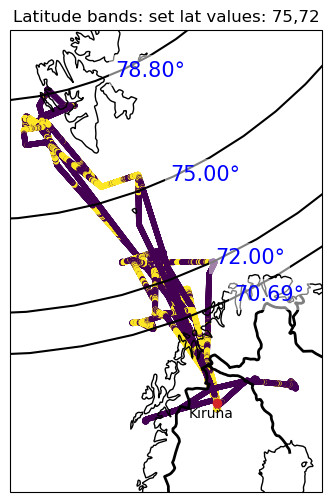

In [6]:
# Investigating different latitude bands: set values for change between bands: 72 and 75

# Define latitudes to set as boundaries
# Here: max, min and the set values of 72 and 75
lat_min = ds_incloud.lat.values.min()
lat_max = ds_incloud.lat.values.max()
# separation points for making latitude bands
lat_b1 = 72
lat_b2 = 75

# set lat-bands to compute between (as an array)
lat_bands = [lat_min, lat_b1, lat_b2, lat_max]

# calculate the number of datapoints per latitude band
ds_set_val_high, ds_set_val_low, ds_set_val_mid, set_val_count_dict = lat_3band_select(lat_bands, ds_incloud)

# plot this variant of latitude bands:
plot_lat_bands(lat_bands, ds, 'set lat values: 75,72')

number of values in 3 bands defined by [np.float32(70.687874), np.float32(73.39115), np.float32(76.09443), np.float32(78.79771)]:
count_low: 3142,count_mid: 840,count_high: 1203


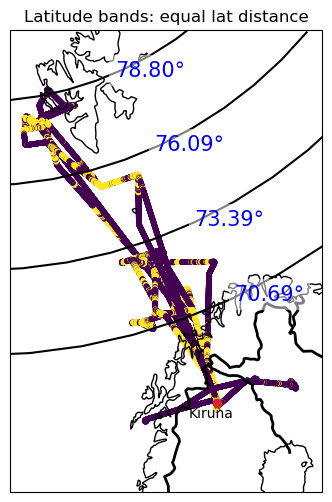

In [7]:
# Investigating different latitude bands: equal latitude-distance between the band edges

# Define latitudes to set as boundaries
# Here: max, min and the set values of 72 and 75
lat_min = ds_incloud.lat.values.min()
lat_max = ds_incloud.lat.values.max()
# separation points: 3 equally large bands
diff = lat_max - lat_min
lat_diff = diff/3

lat_b1 = lat_min + lat_diff
lat_b2 = lat_max - lat_diff

# set lat-bands to compute between (as an array)
lat_bands = [lat_min, lat_b1, lat_b2, lat_max]

# calculate the number of datapoints per latitude band
ds_eq_dist_high, ds_eq_dist_low, ds_eq_dist_mid, eq_dist_count_dict = lat_3band_select(lat_bands, ds_incloud)

# plot this variant of latitude bands:
plot_lat_bands(lat_bands, ds, 'equal lat distance')

number of values in 3 bands defined by [np.float32(70.687874), 72.23711395263672, 75.5077133178711, np.float32(78.79771)]:
count_low: 1728,count_mid: 1729,count_high: 1728


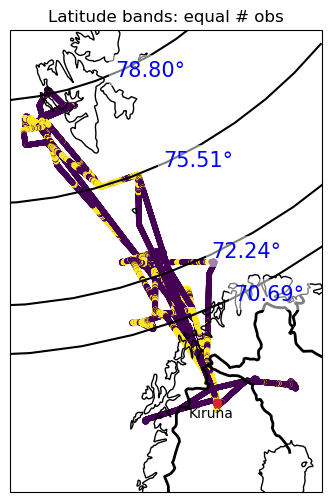

In [8]:
# Investigating different latitude bands: latitude distance based on spread of values (get equal number of values within bands)

# Get the latitude values as an array and sort Sort the DataArray based on latitude values
sorted_lat = np.sort(ds_incloud.lat.values)

# Calculate the indices for splitting into three equal parts
num_per_set = len(sorted_lat) // 3

split_index1 = num_per_set
split_index2 = 2 * num_per_set

# Find the latitude values that define the boundaries
lat_b1 = sorted_lat[split_index1].item()

# If num_points is not divisible by number of bands, add extra points to the middle band
if len(sorted_lat) % 3 != 0:
    lat_b2 = sorted_lat[split_index2 - 1 + len(sorted_lat) % 3].item()
else:
    lat_b2 = sorted_lat[split_index2].item()

lat_max = ds_incloud.lat.values.max()
lat_min = ds_incloud.lat.values.min()

lat_bands = [lat_min, lat_b1, lat_b2, lat_max]

# calculate the number of datapoints per latitude band
ds_eq_obs_high, ds_eq_obs_low, ds_eq_obs_mid, eq_obs_count_dict = lat_3band_select(lat_bands, ds_incloud)

# plot this variant of latitude bands:
plot_lat_bands(lat_bands, ds, 'equal # obs')

In [9]:
ds_incloud

<xarray.Dataset> Size: 1MB
Dimensions:        (time: 5186)
Coordinates:
  * time           (time) datetime64[ns] 41kB 2022-03-22T11:58:01 ... 2022-04...
    lat            (time) float32 21kB 71.29 71.3 71.31 ... 75.0 74.96 74.95
    lon            (time) float32 21kB 20.39 20.41 20.42 ... 20.89 20.88 20.88
    alt            (time) float32 21kB 2.942e+03 2.94e+03 ... 812.7 840.7
    islasid        (time) <U7 145kB 'IS22-02' 'IS22-02' ... 'IS22-11' 'IS22-11'
Data variables: (12/22)
    temp           (time) float32 21kB dask.array<chunksize=(2625,), meta=np.ndarray>
    tas            (time) float32 21kB dask.array<chunksize=(2625,), meta=np.ndarray>
    N_ice_orig     (time) float32 21kB dask.array<chunksize=(2625,), meta=np.ndarray>
    N_liq_orig     (time) float64 41kB dask.array<chunksize=(2625,), meta=np.ndarray>
    N_liq          (time) float64 41kB dask.array<chunksize=(2625,), meta=np.ndarray>
    IWC            (time) float32 21kB dask.array<chunksize=(2625,), meta=np.ndarray>
    ...             ...
    N_ice          (time) float32 21kB dask.array<chunksize=(2625,), meta=np.ndarray>
    N_tot          (time) float64 41kB dask.array<chunksize=(2625,), meta=np.ndarray>
    TWC            (time) float64 41kB dask.array<chunksize=(2625,), meta=np.ndarray>
    incloud        (time) float64 41kB dask.array<chunksize=(2625,), meta=np.ndarray>
    SLF            (time) float64 41kB dask.array<chunksize=(2625,), meta=np.ndarray>
    cloud_phase    (time) object 41kB dask.array<chunksize=(2625,), meta=np.ndarray>

In [ ]:
%skip
# Plot of altitude lines separating regions and cloud layers Needs to be updated more after 

f, ax = plt.subplots(figsize=(9,6))

ax.grid(True)
# plot the limit between the two regions
ax.axvline(lat_bands[1], ls='--', c='k', lw=2) #latbands has the 3 edges of the regions, the middle one/[1] is the separation line
ax.text(lat_bands[1]+2,2850,'Northern')
ax.text(lat_bands[1]-1.2,2850,'Southern')

div_loc = (lat_bands[1]-79)/(70-79) #location of division line in axes coordinates

# Northern marine
ax.axhline(north_ds['alt'].max().values,div_loc,1,ls='--', c='b', lw=2, alpha=0.3) # highest altitude in north_ds
ax.text(78,north_ds['alt'].max().values,f'max: {int(north_ds['alt'].max().values)} m')
ax.axhline(north_ds['alt'].min().values,div_loc,1,ls='--', c='b', lw=2, alpha=0.3) # lowest altitude in north_ds
ax.text(78,north_ds['alt'].min().values,f'min: {int(north_ds['alt'].min().values)} m')

#not doing precip for now
#precip_l = n_precip_list[0]+150 # Precip upper edge (the one layer and + 150 to get the upper edge)
#ax.axhline(precip_l,div_loc,1,ls='--', c='b', lw=2, alpha=0.3)
#ax.text(78,n_precip_list[0],'Precip')

base_l = n_base_list[-1]+150 # base upper edge
ax.axhline(base_l,div_loc,1,ls='--', c='b', lw=2, alpha=0.3)
ax.text(78,n_base_list[-1],'Base')

bulk_l = n_bulk_list[-1]+150 # bulk upper edge
ax.axhline(bulk_l,div_loc,1,ls='--', c='b', lw=2, alpha=0.3)
ax.text(78,n_bulk_list[-1],'Bulk')
ax.text(78,n_top_list[0],'Top')

# Southern marine
ax.axhline(south_ds['alt'].max().values,0,div_loc,ls='--', c='r', lw=2, alpha=0.3) # highest altitude in south_ds
ax.text(70.05,south_ds['alt'].max().values,f'max: {int(south_ds['alt'].max().values)} m')
ax.axhline(south_ds['alt'].min().values,0,div_loc,ls='--', c='r', lw=2, alpha=0.3) # lowest altitude in south_ds
ax.text(70.05,south_ds['alt'].min().values,f'min: {int(south_ds['alt'].min().values)} m')


base_l = s_base_list[-1]+150 # base upper edge
ax.axhline(base_l,0,div_loc,ls='--', c='r', lw=2, alpha=0.3)
ax.text(70.05,s_base_list[-1],'Base')

bulk_l = s_bulk_list[-1]+150 # bulk upper edge
ax.axhline(bulk_l,0,div_loc,ls='--', c='r', lw=2, alpha=0.3)
ax.text(70.05,s_bulk_list[-1],'Bulk')
ax.text(70.05,s_top_list[0],'Top')

# plot the edges between the different layers of cloud
#layers of different bins: s_precip_list,s_base_list,s_bulk_list,s_top_list,s_alt_cats


ax.set_yticks(bin_labels)
plt.title(f'Observations divided between altitude and latitude bins \n \
            Preselection: {pre_text}\n \
            in-cloud threshold method: {th_method}, threshold(s): {th}')
plt.ylim(0,5000)
plt.xlim(79,70)
plt.xlabel('Latitude Bins')
plt.ylabel('Altitude Bins')
plt.show()

In [10]:
# Preparations for plotting values as boxplots per latitude bands

# create categorical altitude variable based on altitude values

# Define the bin edges for the altitude
altitude_bins = np.arange(0, ds_incloud['alt'].max() + 300, 300) # based on max values in data

# digitize altitude data into bins
alt_bin_indices = np.digitize(ds_incloud['alt'], bins = altitude_bins)

#ds_incloud = ds_incloud.assign_coords(altitude_bin=('index', alt_bin_indices))
ds_incloud = ds_incloud.assign_coords(altitude_bin=('time', alt_bin_indices)) # on 'time' dimension

# Label bins by midpoints
bin_labels = (altitude_bins[:-1] + altitude_bins[1:]) / 2
ds_incloud['altitude_bin'].data = bin_labels[alt_bin_indices - 1]
ds_incloud.coords['altitude_bin']=ds_incloud.coords['altitude_bin'].astype(int)

In [11]:
ds_incloud

<xarray.Dataset> Size: 1MB
Dimensions:        (time: 5186)
Coordinates:
  * time           (time) datetime64[ns] 41kB 2022-03-22T11:58:01 ... 2022-04...
    lat            (time) float32 21kB 71.29 71.3 71.31 ... 75.0 74.96 74.95
    lon            (time) float32 21kB 20.39 20.41 20.42 ... 20.89 20.88 20.88
    alt            (time) float32 21kB 2.942e+03 2.94e+03 ... 812.7 840.7
    islasid        (time) <U7 145kB 'IS22-02' 'IS22-02' ... 'IS22-11' 'IS22-11'
    altitude_bin   (time) int64 41kB 2850 2850 2850 2850 ... 450 450 750 750
Data variables: (12/22)
    temp           (time) float32 21kB dask.array<chunksize=(2625,), meta=np.ndarray>
    tas            (time) float32 21kB dask.array<chunksize=(2625,), meta=np.ndarray>
    N_ice_orig     (time) float32 21kB dask.array<chunksize=(2625,), meta=np.ndarray>
    N_liq_orig     (time) float64 41kB dask.array<chunksize=(2625,), meta=np.ndarray>
    N_liq          (time) float64 41kB dask.array<chunksize=(2625,), meta=np.ndarray>
    IWC            (time) float32 21kB dask.array<chunksize=(2625,), meta=np.ndarray>
    ...             ...
    N_ice          (time) float32 21kB dask.array<chunksize=(2625,), meta=np.ndarray>
    N_tot          (time) float64 41kB dask.array<chunksize=(2625,), meta=np.ndarray>
    TWC            (time) float64 41kB dask.array<chunksize=(2625,), meta=np.ndarray>
    incloud        (time) float64 41kB dask.array<chunksize=(2625,), meta=np.ndarray>
    SLF            (time) float64 41kB dask.array<chunksize=(2625,), meta=np.ndarray>
    cloud_phase    (time) object 41kB dask.array<chunksize=(2625,), meta=np.ndarray>

In [12]:
# Early, Mid, Late Datasets Split
early_ds = ds_incloud.where(ds_incloud['lat'] >= 75, drop=True)
mid_ds = ds_incloud.where((ds_incloud['lat'] < 75) & (ds_incloud['lat'] >= 72), drop=True)
late_ds = ds_incloud.where(ds_incloud['lat'] < 72, drop=True)

# grouping by altitude bin
early_ds_season = early_ds.groupby('altitude_bin')
mid_ds_season = mid_ds.groupby('altitude_bin')
late_ds_season = late_ds.groupby('altitude_bin')

# creating dataframes for easier reuse of plots
early_df = early_ds.to_dataframe().reset_index()
mid_df = mid_ds.to_dataframe().reset_index()
late_df = late_ds.to_dataframe().reset_index()

In [18]:
early_df['altitude_bin'].unique()
test = early_df[early_df['altitude_bin']==1950]


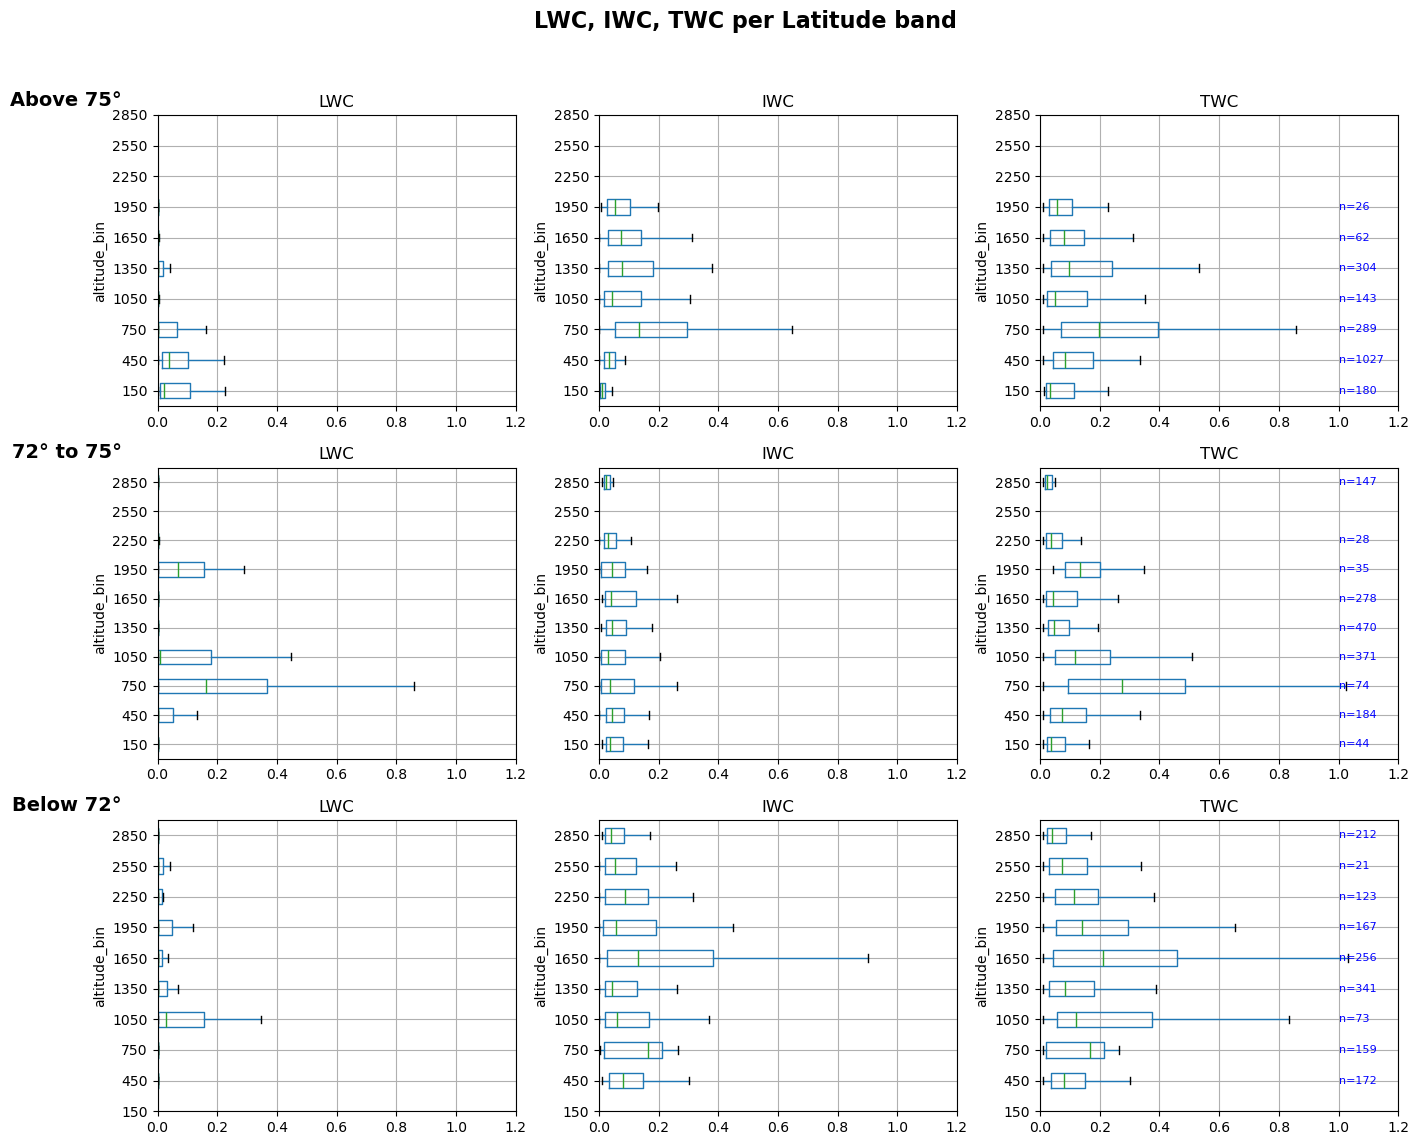

In [14]:
import matplotlib.pyplot as plt

# Define the dataframes and columns
row_titles = ['Above 75°', '72° to 75°', 'Below 72°']
dfs = [early_df, mid_df, late_df]
columns = ['LWC', 'IWC', 'TWC']
# set count for each row in TWC plots (covers all plots
# Get list of all available altitude categories in the full dataset
alt_cats = np.unique(ds_incloud['altitude_bin'].values)

# subplotsize
n_cols = len(columns)
n_rows = len(dfs)

fig, ax = plt.subplots(n_cols, n_rows, figsize=(15, 12))


# Plot the data and add the count of observations
for row, df in enumerate(dfs):
    altitude_bins = df['altitude_bin'].unique()
    positions = [np.where(alt_cats == alt)[0][0] + 1 for alt in altitude_bins]
    for col, column in enumerate(columns):
        df.boxplot(column=column, by='altitude_bin', ax=ax[row, col], positions=positions, vert=False, showfliers=False)
        ax[row, col].set_yticks(range(1, len(alt_cats) + 1))
        ax[row, col].set_yticklabels(alt_cats)

        if col == len(columns) - 1:
            # Add counts only to the last plot
            counts = df['altitude_bin'].value_counts() #get the number of observations per altitude bin
            for group, count in counts.items():
                # for each item in the counts per altitude bin:
                # 1: find out where it is located in the array of sorted altitude bins
                # 2: plot the count as text by the boxplot located at this location.
                index_of_group = np.where(alt_cats==group)[0] +1  # change from 0 base to 1 base
                ax[row,2].text(1, index_of_group, f'n={count}', verticalalignment='center', fontsize=8, color='blue')
           

# Set titles for each row
for i, title in enumerate(row_titles):
    ax[i, 0].text(-0.1, 1.05, title, transform=ax[i, 0].transAxes, fontsize=14, fontweight='bold', va='center', ha='right')

# Adjust layout
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle(f'{', '.join(str(e) for e in columns)} per Latitude band', fontsize=16, fontweight='bold')
plt.setp(ax, xlim=(0, 1.2))

# Save the figure
#plt.savefig(f'Latitudebands/LWC_IWC_per_Latitude_bands_TWCthreshold.png')
plt.savefig(f'Latitudebands/LWC_th/LWC_IWC_per_Latitude_bands_LWCthreshold.png')


In [15]:
counts = early_df['altitude_bin'].value_counts()
print(counts)
counts[450]

altitude_bin
450     1027
1350     304
750      289
150      180
1050     143
1650      62
1950      26
Name: count, dtype: int64


np.int64(1027)

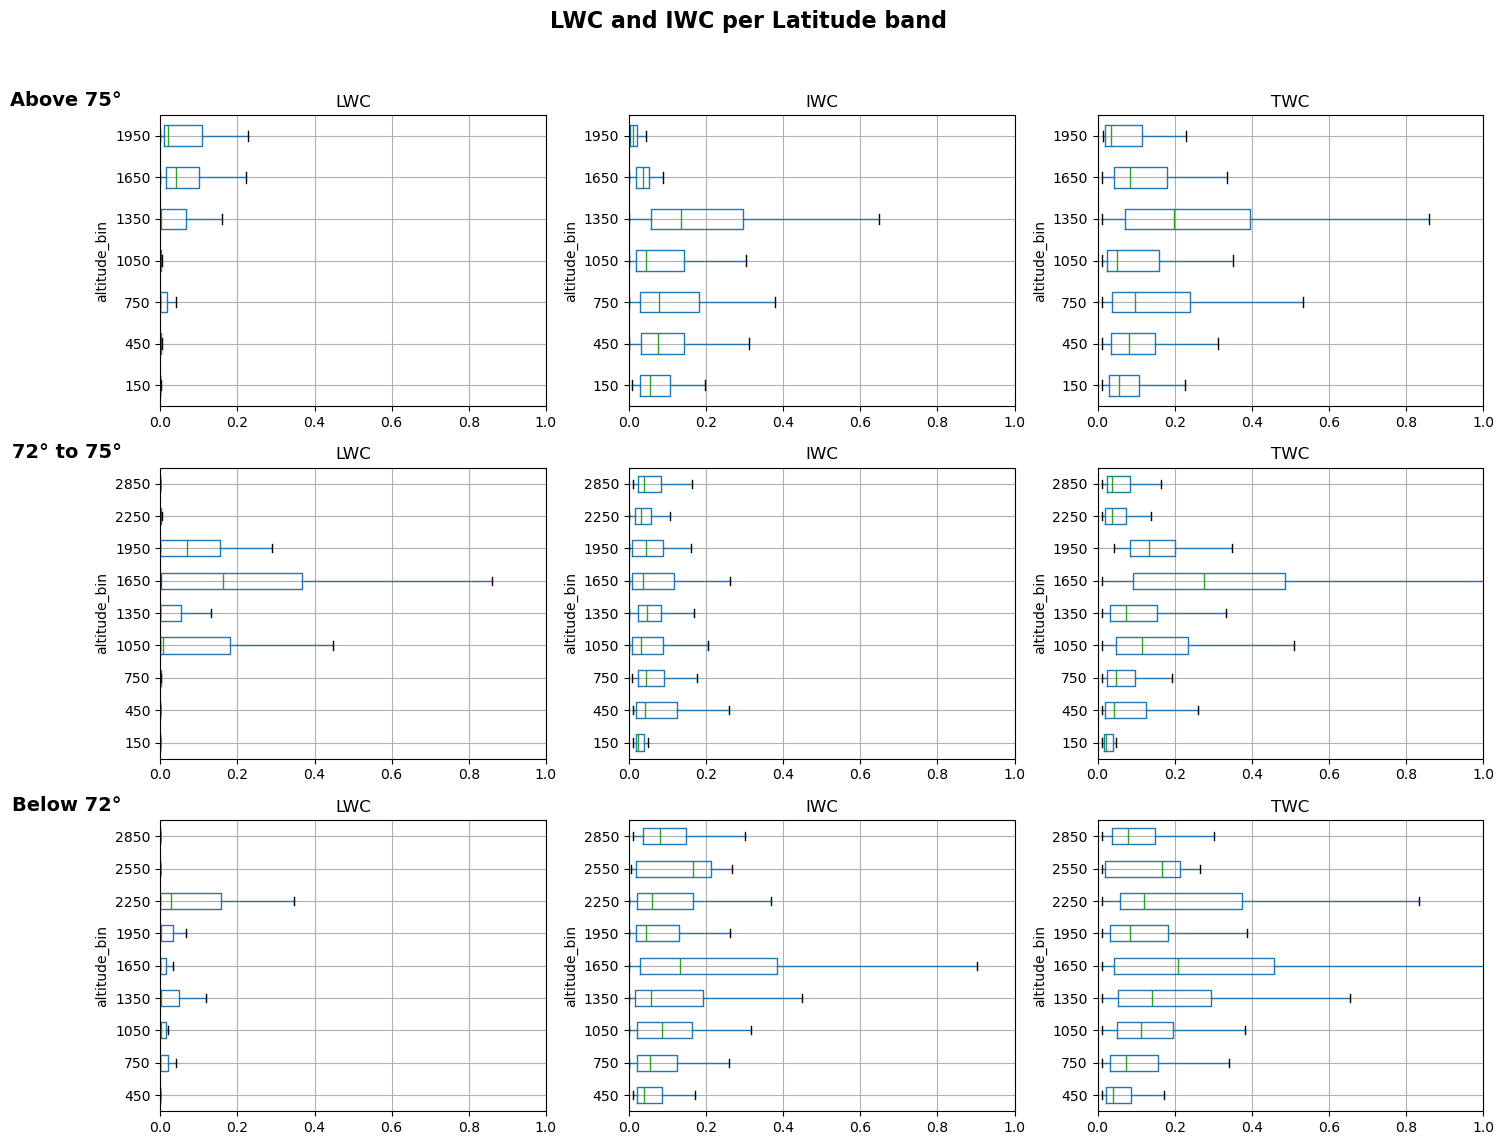

In [16]:
# LWC/IWC


fig, ax = plt.subplots(3,3,figsize=(15, 12))

# add the number of observations!!
early_df.boxplot(column='LWC', by= 'altitude_bin', ax = ax[0,0], vert=False, showfliers=False)
early_df.boxplot(column='IWC', by= 'altitude_bin', ax = ax[0,1], vert=False, showfliers=False)
early_df.boxplot(column='TWC', by= 'altitude_bin', ax = ax[0,2], vert=False, showfliers=False)


mid_df.boxplot(column='LWC', by= 'altitude_bin', ax = ax[1,0], vert=False, showfliers=False)
mid_df.boxplot(column='IWC', by= 'altitude_bin', ax = ax[1,1], vert=False, showfliers=False)
mid_df.boxplot(column='TWC', by= 'altitude_bin', ax = ax[1,2], vert=False, showfliers=False)

late_df.boxplot(column='LWC', by= 'altitude_bin', ax = ax[2,0], vert=False, showfliers=False)
late_df.boxplot(column='IWC', by= 'altitude_bin', ax = ax[2,1], vert=False, showfliers=False)
late_df.boxplot(column='TWC', by= 'altitude_bin', ax = ax[2,2], vert=False, showfliers=False)


# Set titles for each row
row_titles = ['Above 75°', '72° to 75°', 'Below 72°']
for i, title in enumerate(row_titles):
    ax[i, 0].text(-0.1, 1.05, title, transform=ax[i, 0].transAxes,fontsize=14, fontweight='bold', va='center', ha='right')

# Adjust layout
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('LWC and IWC per Latitude band', fontsize=16, fontweight='bold')
plt.setp(ax, xlim=(0,1))

plt.savefig(f'Latitudebands/LWC_IWC_per_Latitude_bands.png')


In [17]:
# MVD

# obs counts for plotting
early_oc_cdp = early_df.groupby('Altitude_bin', observed=True)['cdp LWC corr (g/m^3)'].count()
early_oc_cip = early_df.groupby('Altitude_bin', observed=True)['cip IWC (g/m^3)'].count()
mid_oc_cdp = mid_df.groupby('Altitude_bin', observed=True)['cdp LWC corr (g/m^3)'].count()
mid_oc_cip = mid_df.groupby('Altitude_bin', observed=True)['cip IWC (g/m^3)'].count()
late_oc_cdp = late_df.groupby('Altitude_bin', observed=True)['cdp LWC corr (g/m^3)'].count()
late_oc_cip = late_df.groupby('Altitude_bin', observed=True)['cip IWC (g/m^3)'].count()

fig, ax = plt.subplots(3,2,figsize=(15, 12))

# add the number of observations!!
early_df.boxplot(column='cdp MVD (um)', by= 'Altitude_bin', ax = ax[0,0], vert=False, showfliers=False)
early_df.boxplot(column='cip MVD (um)', by= 'Altitude_bin', ax = ax[0,1], vert=False, showfliers=False)


mid_df.boxplot(column='cdp MVD (um)', by= 'Altitude_bin', ax = ax[1,0], vert=False, showfliers=False)
mid_df.boxplot(column='cip MVD (um)', by= 'Altitude_bin', ax = ax[1,1], vert=False, showfliers=False)

late_df.boxplot(column='cdp MVD (um)', by= 'Altitude_bin', ax = ax[2,0], vert=False, showfliers=False)
late_df.boxplot(column='cip MVD (um)', by= 'Altitude_bin', ax = ax[2,1], vert=False, showfliers=False)

# Annotate the boxplots with the number of observations
# 75-cdp
for i, (cat, count) in enumerate(early_oc_cdp.items()):
    if count>0:
        ax[0,0].text(40, i + 1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')

# 75-cip
for i, (cat, count) in enumerate(early_oc_cip.items()):
    index_of_cat = alt_cats.get_loc(cat) # get index of target_interval in list of bins
    if count>0:
        ax[0,1].text(1400, index_of_cat + 1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')
# 75-72-cdp
for i, (cat, count) in enumerate(mid_oc_cdp.items()):
    index_of_cat = alt_cats.get_loc(cat) # get index of target_interval in list of bins
    if count>0:
        ax[1,0].text(40, index_of_cat + 1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')

# 75-72-cip
for i, (cat, count) in enumerate(mid_oc_cip.items()):
    index_of_cat = alt_cats.get_loc(cat) # get index of target_interval in list of bins
    if count>0:
        ax[1,1].text(1400, index_of_cat + 1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')
# 72-cdp
for i, (cat, count) in enumerate(late_oc_cdp.items()):
    index_of_cat = alt_cats.get_loc(cat) # get index of target_interval in list of bins
    if count>0:
        ax[2,0].text(40, index_of_cat + 1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')

# 72-cip
for i, (cat, count) in enumerate(late_oc_cip.items()):
    index_of_cat = alt_cats.get_loc(cat) # get index of target_interval in list of bins
    if count>0:
        ax[2,1].text(1400, index_of_cat+1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')
      

# Set titles for each row
row_titles = ['Above 75°', '72° to 75°', 'Below 72°']
for i, title in enumerate(row_titles):
    ax[i, 0].text(-0.1, 1.05, title, transform=ax[i, 0].transAxes,fontsize=14, fontweight='bold', va='center', ha='right')

# Adjust layout
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('MVD per Latitude band', fontsize=16, fontweight='bold')
#plt.setp(ax, xlim=(0,1))

plt.savefig(f'Latitudebands/MVD_per_Latitude_bands.png')
#plt.show()

KeyError: 'Altitude_bin'

In [ ]:
# Number concentration

# obs counts for plotting
early_oc_cdp = early_df.groupby('Altitude_bin', observed=True)['cdp NumConc corr (#/cm^3)'].count()
early_oc_cip = early_df.groupby('Altitude_bin', observed=True)['cip NumConc (#/cm^3)'].count()
mid_oc_cdp = mid_df.groupby('Altitude_bin', observed=True)['cdp NumConc corr (#/cm^3)'].count()
mid_oc_cip = mid_df.groupby('Altitude_bin', observed=True)['cip NumConc (#/cm^3)'].count()
late_oc_cdp = late_df.groupby('Altitude_bin', observed=True)['cdp NumConc corr (#/cm^3)'].count()
late_oc_cip = late_df.groupby('Altitude_bin', observed=True)['cip NumConc (#/cm^3)'].count()

fig, ax = plt.subplots(3,2,figsize=(15, 12))

# add the number of observations!!
early_df.boxplot(column='cdp NumConc corr (#/cm^3)', by= 'Altitude_bin', ax = ax[0,0], vert=False, showfliers=False)
early_df.boxplot(column='cip NumConc (#/cm^3)', by= 'Altitude_bin', ax = ax[0,1], vert=False, showfliers=False)


mid_df.boxplot(column='cdp NumConc corr (#/cm^3)', by= 'Altitude_bin', ax = ax[1,0], vert=False, showfliers=False)
mid_df.boxplot(column='cip NumConc (#/cm^3)', by= 'Altitude_bin', ax = ax[1,1], vert=False, showfliers=False)

late_df.boxplot(column='cdp NumConc corr (#/cm^3)', by= 'Altitude_bin', ax = ax[2,0], vert=False, showfliers=False)
late_df.boxplot(column='cip NumConc (#/cm^3)', by= 'Altitude_bin', ax = ax[2,1], vert=False, showfliers=False)

# Find common x-axis limits
x_max = max(
    early_df['cdp NumConc corr (#/cm^3)'].max(),
    early_df['cip NumConc (#/cm^3)'].max(),
    mid_df['cdp NumConc corr (#/cm^3)'].max(),
    mid_df['cip NumConc (#/cm^3)'].max(),
    late_df['cdp NumConc corr (#/cm^3)'].max(),
    late_df['cip NumConc (#/cm^3)'].max()
)

# Set x-scale to logarithmic and use common x-limits for all subplots
for i in range(3):
    ax[i, 0].set_xscale('log')
    ax[i, 0].set_xlim(0, x_max)
    ax[i, 1].set_xscale('log')
    ax[i, 1].set_xlim(0, x_max)

# Annotate the boxplots with the number of observations
# 75-cdp
for i, (cat, count) in enumerate(early_oc_cdp.items()):
    if count>0:
        ax[0,0].text(140, i + 1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')

# 75-cip
for i, (cat, count) in enumerate(early_oc_cip.items()):
    index_of_cat = alt_cats.get_loc(cat) # get index of target_interval in list of bins
    if count>0:
        ax[0,1].text(140, index_of_cat + 1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')
# 75-72-cdp
for i, (cat, count) in enumerate(mid_oc_cdp.items()):
    index_of_cat = alt_cats.get_loc(cat) # get index of target_interval in list of bins
    if count>0:
        ax[1,0].text(140, index_of_cat + 1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')

# 75-72-cip
for i, (cat, count) in enumerate(mid_oc_cip.items()):
    index_of_cat = alt_cats.get_loc(cat) # get index of target_interval in list of bins
    if count>0:
        ax[1,1].text(140, index_of_cat + 1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')
# 72-cdp
for i, (cat, count) in enumerate(late_oc_cdp.items()):
    index_of_cat = alt_cats.get_loc(cat) # get index of target_interval in list of bins
    if count>0:
        ax[2,0].text(140, index_of_cat + 1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')

# 72-cip
for i, (cat, count) in enumerate(late_oc_cip.items()):
    index_of_cat = alt_cats.get_loc(cat) # get index of target_interval in list of bins
    if count>0:
        ax[2,1].text(140, index_of_cat+1, f'n={count}', verticalalignment='center', fontsize=8, color='blue')
      

# Set titles for each row
row_titles = ['Above 75°', '72° to 75°', 'Below 72°']
for i, title in enumerate(row_titles):
    ax[i, 0].text(-0.1, 1.05, title, transform=ax[i, 0].transAxes,fontsize=14, fontweight='bold', va='center', ha='right')

# Adjust layout
fig.tight_layout()
plt.suptitle('Number concentration per Latitude band', fontsize=16, fontweight='bold')

plt.savefig(f'Latitudebands/N_per_Latitude_bands.png')
#plt.show()

In [ ]:
# plotting the mean and the spread (std) per height
# -- southern marine
# get the mean values per height bin
s_twc_mean = south_df.groupby('altitude_bin')['TWC'].mean()
s_lwc_mean = south_df.groupby('altitude_bin')['LWC corr'].mean()
s_iwc_mean = south_df.groupby('altitude_bin')['IWC100'].mean()

# get the std values per height bin
s_twc_std = south_df.groupby('altitude_bin')['TWC'].std()
s_lwc_std = south_df.groupby('altitude_bin')['LWC corr'].std()
s_iwc_std = south_df.groupby('altitude_bin')['IWC100'].std()

# get the max values per height bin
s_twc_mx = south_df.groupby('altitude_bin')['TWC'].max()
s_lwc_mx = south_df.groupby('altitude_bin')['LWC corr'].max()
s_iwc_mx = south_df.groupby('altitude_bin')['IWC100'].max()

# get the std values per height bin
s_twc_mn = south_df.groupby('altitude_bin')['TWC'].min()
s_lwc_mn = south_df.groupby('altitude_bin')['LWC corr'].min()
s_iwc_mn = south_df.groupby('altitude_bin')['IWC100'].min()

# -- nothern marine
n_twc_mean = north_df.groupby('altitude_bin')['TWC'].mean()
n_lwc_mean = north_df.groupby('altitude_bin')['LWC corr'].mean()
n_iwc_mean = north_df.groupby('altitude_bin')['IWC100'].mean()

# get the std values per height bin
n_twc_std = north_df.groupby('altitude_bin')['TWC'].std()
n_lwc_std = north_df.groupby('altitude_bin')['LWC corr'].std()
n_iwc_std = north_df.groupby('altitude_bin')['IWC100'].std()

# get the max values per height bin
n_twc_mx = north_df.groupby('altitude_bin')['TWC'].max()
n_lwc_mx = north_df.groupby('altitude_bin')['LWC corr'].max()
n_iwc_mx = north_df.groupby('altitude_bin')['IWC100'].max()

# get the std values per height bin
n_twc_mn = north_df.groupby('altitude_bin')['TWC'].min()
n_lwc_mn = north_df.groupby('altitude_bin')['LWC corr'].min()
n_iwc_mn = north_df.groupby('altitude_bin')['IWC100'].min()

# plot the values
fig, axs = plt.subplots(2,2, figsize=(15,15))
axs[1,0].plot(s_twc_mean, s_twc_mean.index, label = 'TWC', lw=2,color = 'yellow')
axs[1,0].plot(s_lwc_mean, s_lwc_mean.index, label = 'LWC', lw=2,color = 'red')
axs[1,0].plot(s_iwc_mean, s_iwc_mean.index, label = 'IWC', lw=2,color = 'blue')

# alt std
axs[1,0].fill_betweenx(s_twc_mean.index, s_twc_mean+s_twc_std, s_twc_mean-s_twc_std, facecolor='yellow', alpha=0.5, label='TWC std')
axs[1,0].fill_betweenx(s_lwc_mean.index, s_lwc_mean+s_lwc_std, s_lwc_mean-s_lwc_std, facecolor='red', alpha=0.5, label='LWC std')
axs[1,0].fill_betweenx(s_iwc_mean.index, s_iwc_mean+s_iwc_std, s_iwc_mean-s_iwc_std, facecolor='blue', alpha=0.5, label='IWC std')

axs[1,0].set_title('Southern Marine (std)')
axs[1,0].set_ylabel('Altitude (m)')
axs[1,0].set_xlabel('g/m³')
axs[1,0].legend(loc='upper right')
axs[1,0].grid()

axs[1,1].plot(s_twc_mean, s_twc_mean.index, label = 'TWC', lw=2,color = 'yellow')
axs[1,1].plot(s_lwc_mean, s_lwc_mean.index, label = 'LWC', lw=2,color = 'red')
axs[1,1].plot(s_iwc_mean, s_iwc_mean.index, label = 'IWC', lw=2,color = 'blue')

# alt max/min
axs[1,1].fill_betweenx(s_twc_mean.index, s_twc_mx, s_twc_mn, facecolor='yellow', alpha=0.5, label='TWC mx-mn')
axs[1,1].fill_betweenx(s_lwc_mean.index, s_lwc_mx, s_lwc_mn, facecolor='red', alpha=0.5, label='LWC mx-mn')
axs[1,1].fill_betweenx(s_iwc_mean.index, s_iwc_mx, s_iwc_mn, facecolor='blue', alpha=0.5, label='IWC mx-mn')


axs[1,1].set_title('Southern Marine (max/min)')
axs[1,1].set_ylabel('Altitude (m)')
axs[1,1].set_xlabel('g/m³')
axs[1,1].legend(loc='upper right')
axs[1,1].grid()

# northern
axs[0,0].plot(n_twc_mean, n_twc_mean.index, label = 'TWC', lw=2,color = 'yellow')
axs[0,0].plot(n_lwc_mean, n_lwc_mean.index, label = 'LWC', lw=2,color = 'red')
axs[0,0].plot(n_iwc_mean, n_iwc_mean.index, label = 'IWC', lw=2,color = 'blue')

# alt std
axs[0,0].fill_betweenx(n_twc_mean.index, n_twc_mean+n_twc_std, n_twc_mean-n_twc_std, facecolor='yellow', alpha=0.5, label='TWC std')
axs[0,0].fill_betweenx(n_lwc_mean.index, n_lwc_mean+n_lwc_std, n_lwc_mean-n_lwc_std, facecolor='red', alpha=0.5, label='LWC std')
axs[0,0].fill_betweenx(n_iwc_mean.index, n_iwc_mean+n_iwc_std, n_iwc_mean-n_iwc_std, facecolor='blue', alpha=0.5, label='IWC std')

axs[0,0].set_title('Northern Marine (std)')
axs[0,0].set_ylabel('Altitude (m)')
axs[0,0].set_xlabel('g/m³')
axs[0,0].legend(loc='upper right')
axs[0,0].grid()

axs[0,1].plot(n_twc_mean, n_twc_mean.index, label = 'TWC', lw=2,color = 'yellow')
axs[0,1].plot(n_lwc_mean, n_lwc_mean.index, label = 'LWC', lw=2,color = 'red')
axs[0,1].plot(n_iwc_mean, n_iwc_mean.index, label = 'IWC', lw=2,color = 'blue')

# alt max/min
axs[0,1].fill_betweenx(n_twc_mean.index, n_twc_mx, n_twc_mn, facecolor='yellow', alpha=0.5, label='TWC mx-mn')
axs[0,1].fill_betweenx(n_lwc_mean.index, n_lwc_mx, n_lwc_mn, facecolor='red', alpha=0.5, label='LWC mx-mn')
axs[0,1].fill_betweenx(n_iwc_mean.index, n_iwc_mx, n_iwc_mn, facecolor='blue', alpha=0.5, label='IWC mx-mn')


axs[0,1].set_title('Northern Marine (max/min)')
axs[0,1].set_ylabel('Altitude (m)')
axs[0,1].set_xlabel('g/m³')
axs[0,1].legend(loc='upper right')
axs[0,1].grid()

fig.suptitle('LWC threshold')
plt.savefig(save_path + f'{th_method}/WC_spread_per_Latitude_bands_{th_method}.png')